In [229]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [230]:
train_df.info()

train_df.describe()

train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [231]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
train_df['HasCabin'] = train_df['Cabin'].notnull().astype(int)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
train_df['Age*Class'] = train_df['Age'] * train_df['Pclass']
train_df['Fare'] = np.log1p(train_df['Fare'])
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

train_df.isnull().sum()
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,FamilySize,IsAlone,Age*Class,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,22.0,1,0,2.110213,0,2,0,66.0,True,False,True,False,True,False,False
1,1,1,38.0,1,0,4.280593,1,2,0,38.0,False,False,False,False,False,True,False
2,1,3,26.0,0,0,2.188856,0,1,1,78.0,False,False,True,True,False,False,False
3,1,1,35.0,1,0,3.990834,1,2,0,35.0,False,False,True,False,False,True,False
4,0,3,35.0,0,0,2.202765,0,1,1,105.0,True,False,True,False,True,False,False


In [233]:

X = train_df.drop('Survived', axis=1)
y = train_df['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


print(f'Training data shape: {X_train.shape}, Validation data shape: {X_valid.shape}')


Training data shape: (712, 16), Validation data shape: (179, 16)


In [234]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
dt = DecisionTreeClassifier(max_depth=4, random_state=42)

In [235]:
estimators = [
    ('rf', rf),
    ('dt', dt)
]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

In [236]:
stacking_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=5,
                                                       random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=4,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

In [237]:
y_pred = stacking_model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f'Stacking Model Validation Accuracy: {accuracy:.4f}')

Stacking Model Validation Accuracy: 0.8101


In [238]:
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])
test_df['HasCabin'] = test_df['Cabin'].notnull().astype(int)
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)
test_df['Age*Class'] = test_df['Age'] * test_df['Pclass']
test_df['Fare'] = np.log1p(test_df['Fare'])
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
X_train, test_df = X.align(test_df, join='left', axis=1, fill_value=0)


In [239]:
test_predictions = stacking_model.predict(test_df)

submission = pd.DataFrame({
    'PassengerId': pd.read_csv('../data/test.csv')['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('submission.csv', index=False)

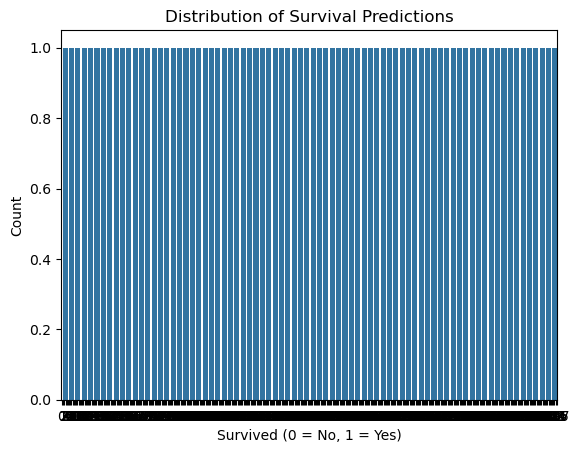

Распределение предсказаний: {0: 267, 1: 151}


In [242]:

sns.countplot(predictions)
plt.title('Distribution of Survival Predictions')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

unique, counts = np.unique(predictions, return_counts=True)
print("Распределение предсказаний:", dict(zip(unique, counts)))